# Data Wrangling 2 Macro Economic Indicators

In [2]:
#import packages

import pandas as pd
from pandas_datareader.data import DataReader
from pandas.tseries.offsets import MonthEnd
from datetime import date
import requests
import collections
import pandas as pd 
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np


#### <font color=blue> Text Import GDP, Mortgage Rates, Unemployment Rates, Consumer Sentiment, and Housing Startings from Fed Reserve Database using pandas datareader package

In [3]:
#function to switch monthly dates to month end date - setting this up so we can merge to the housing data on the date column
def ME(field, num):
    return pd.to_datetime(field) + MonthEnd(num)

In [4]:
#define start date
start = date(1990,1,1)

#GDP Data
GDP = DataReader('GDPC1', 'fred', start )
GDP['growth'] = GDP.GDPC1.pct_change(periods = 1)
GDP = GDP.reset_index()
GDP.columns = ['DATE', 'GDP', 'GDP Growh']

#ensure all monthly dates represent month end date
GDP['DATE'] = pd.to_datetime(GDP['DATE']) + MonthEnd(1)


#30 Year fixed mortgage interest rate
MortRate = DataReader('MORTGAGE30US', 'fred',start).reset_index()
MortRate = MortRate.set_index(pd.to_datetime(MortRate.DATE)).drop(columns = 'DATE')

#data pulls weekly rates - resample to monthly average
MortRate = MortRate.resample('M').mean().reset_index()

#import unemployment rate
UNRATE = DataReader('UNRATE', 'fred',start).reset_index()
#ensure all monthly dates represent month end date
UNRATE['DATE'] = pd.to_datetime(UNRATE['DATE']) + MonthEnd(1)


#import Consumer Sentiment Score
CS = DataReader('UMCSENT', 'fred', start).reset_index()
#ensure all monthly dates represent month end date
CS['DATE'] = pd.to_datetime(CS['DATE']) + MonthEnd(1)


HOUST = DataReader('HOUST', 'fred',start).reset_index()
#ensure all monthly dates represent month end date
HOUST.DATE = HOUST.DATE.apply(ME, args = (1,))

In [5]:
# define function to pull Qundal Data

def Quandl(url, param_dict, col_names):
    
    r = requests.get(url, params = param_dict)
    json_data = r.json()
    df = pd.DataFrame(json_data['dataset']['data'], columns = col_names)
    df.DATE = df.DATE.astype('datetime64[ns]')
    return df





In [6]:
# Import S&P 500 P&E Ratios
API_KEY = 'pTsozhv5F_xzhfyMkVQi'
url = "https://www.quandl.com/api/v3/datasets/MULTPL/SP500_PE_RATIO_MONTH.json"
p = dict(start_date = '1990-01-01' , api_key = API_KEY)

#call my quandl function
PE = Quandl(url, p, ['DATE', 'PE_Ratio'])


#most months produced only one record (at the beginning of the month)
#some were producing two records one on the first and one on the last. Filter data to only first of month

PE = PE[pd.to_datetime(PE["DATE"]).dt.is_month_end == False]
#switch dates to month end date
PE['DATE'] = pd.to_datetime(PE['DATE']) + MonthEnd(-1)

In [7]:
#Import S&P Prices and Get Growth Rate by Quarter

API_KEY = 'pTsozhv5F_xzhfyMkVQi'
url = "https://www.quandl.com/api/v3/datasets/MULTPL/SP500_REAL_PRICE_MONTH.json"
p = dict(start_date = '1990-01-01' , api_key = API_KEY)

#call my quandl function
SP = Quandl(url, p, ['DATE', 'SP_Value'])
SP = SP.sort_values(by= 'DATE')


#Calculate percent changes from prior quarter
SP['SP500 Growth'] = SP['SP_Value'].pct_change()

SP = SP[pd.to_datetime(SP["DATE"]).dt.is_month_end == False]
SP.DATE = SP.DATE.apply(ME, args = (-1,))

In [8]:
#Merge everything together
dfMacro = MortRate.merge(GDP, on = 'DATE', how = 'left').fillna(method = "ffill")
dfMacro = dfMacro.merge(UNRATE, on = 'DATE', how = 'left')
dfMacro = dfMacro.merge(CS, on = 'DATE', how = 'left')
dfMacro = dfMacro.merge(HOUST, on = 'DATE', how = 'left')
dfMacro = dfMacro.merge(SP, on = 'DATE', how = 'left')
dfMacro = dfMacro.merge(PE, on = 'DATE', how = 'left')

In [9]:
#Review NA Values
dfMacro.isna().sum()

DATE            0
MORTGAGE30US    0
GDP             0
GDP Growh       3
UNRATE          1
UMCSENT         1
HOUST           1
SP_Value        2
SP500 Growth    2
PE_Ratio        2
dtype: int64

In [10]:
#drop NA values
dfMacro = dfMacro.dropna()

In [11]:
dfMacro

,DATE,MORTGAGE30US,GDP,GDP Growh,UNRATE,UMCSENT,HOUST,SP_Value,SP500 Growth,PE_Ratio
3,1990-04-30,10.3700,9392.251,0.003629,5.4,93.9,1248.0,350.25,0.035691,16.37
4,1990-05-31,10.4775,9392.251,0.003629,5.4,90.6,1212.0,360.39,0.028951,16.95
5,1990-06-30,10.1640,9392.251,0.003629,5.2,88.3,1177.0,360.03,-0.000999,16.81
6,1990-07-31,10.0350,9398.499,0.000665,5.5,88.2,1171.0,330.75,-0.081327,15.33
7,1990-08-31,10.1000,9398.499,0.000665,5.7,76.4,1115.0,315.41,-0.046379,14.51
...,...,...,...,...,...,...,...,...,...,...
367,2020-05-31,3.2325,17302.511,-0.089861,13.3,72.3,1038.0,3104.66,0.063382,31.29
368,2020-06-30,3.1625,17302.511,-0.089861,11.1,78.1,1265.0,3207.62,0.034619,32.33
369,2020-07-31,3.0160,18583.501,0.074035,10.2,72.5,1487.0,3391.71,0.036865,34.18
370,2020-08-31,2.9350,18583.501,0.074035,8.4,74.1,1373.0,3365.52,-0.038508,33.92


In [12]:
#import home values from data wrangling 1
os.chdir(r'C:\Users\nickmrry\Desktop\Springboard')
HomeValues = pd.read_csv('HomeVals_Clustered.csv')

In [13]:
#filter to cluster 2, summarize by cluster 2 average values, merge with Macro Eco Data
avg_c2 = HomeValues[HomeValues.labels == 2].groupby('Date')['Price'].mean().reset_index()
avg_c2.columns = ['DATE', 'Price']
avg_c2.DATE = pd.to_datetime(avg_c2.DATE)
df = avg_c2.merge(dfMacro, on = 'DATE', how = 'left')

In [14]:
avg_c2.dtypes

DATE     datetime64[ns]
Price           float64
dtype: object

# Examine Correlation of Variables

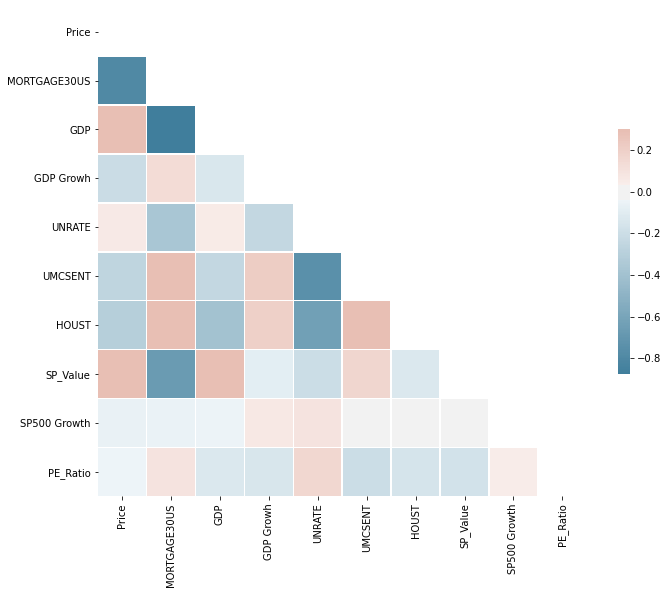

,Price,MORTGAGE30US,GDP,GDP Growh,UNRATE,UMCSENT,HOUST,SP_Value,SP500 Growth,PE_Ratio
Price,1.000000,-0.793881,0.958580,-0.210219,0.063389,-0.260464,-0.306474,0.839414,-0.057480,-0.037333
MORTGAGE30US,-0.793881,1.000000,-0.876605,0.143446,-0.362248,0.390097,0.524581,-0.664654,-0.051952,0.098929
GDP,0.958580,-0.876605,1.000000,-0.135649,0.058389,-0.241879,-0.393158,0.843315,-0.043989,-0.125817
GDP Growh,-0.210219,0.143446,-0.135649,1.000000,-0.241925,0.217725,0.199608,-0.085881,0.066900,-0.144161
UNRATE,0.063389,-0.362248,0.058389,-0.241925,1.000000,-0.743033,-0.630975,-0.205529,0.097377,0.168325
UMCSENT,-0.260464,0.390097,-0.241879,0.217725,-0.743033,1.000000,0.632601,0.171688,0.016832,-0.202895
HOUST,-0.306474,0.524581,-0.393158,0.199608,-0.630975,0.632601,1.000000,-0.129631,-0.022268,-0.151303
SP_Value,0.839414,-0.664654,0.843315,-0.085881,-0.205529,0.171688,-0.129631,1.000000,0.025983,-0.167655
SP500 Growth,-0.057480,-0.051952,-0.043989,0.066900,0.097377,0.016832,-0.022268,0.025983,1.000000,0.050452
PE_Ratio,-0.037333,0.098929,-0.125817,-0.144161,0.168325,-0.202895,-0.151303,-0.167655,0.050452,1.000000


In [15]:
corr = df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
s = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


plt.show()
corr

### Plot With Price with Various X Variables

In [16]:
def dual_axis(x, y1,y2, y1_title, y2_title):

    fig, ax1 = plt.subplots()
    t = x
    data1 = y1
    data2 = y2

    color = 'tab:red'
    ax1.set_xlabel('Month')
    ax1.set_ylabel(y1_title, color=color)
    ax1.plot(t, data1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel(y2_title, color=color)  # we already handled the x-label with ax1
    ax2.plot(t, data2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    plt.show()

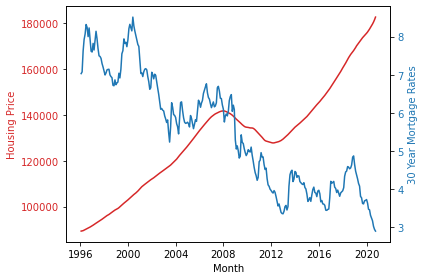

In [17]:
dual_axis(df.DATE, df.Price, df.MORTGAGE30US, "Housing Price", "30 Year Mortgage Rates")

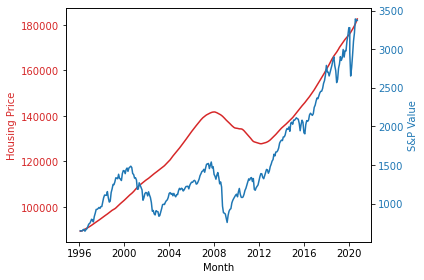

In [18]:
dual_axis(df.DATE, df.Price, df.SP_Value, "Housing Price", "S&P Value")

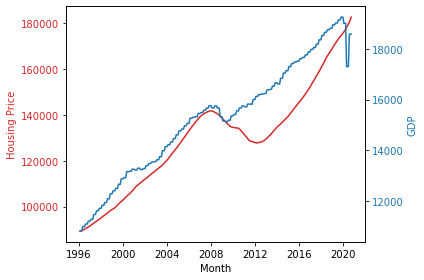

In [19]:
dual_axis(df.DATE, df.Price, df.GDP, "Housing Price", "GDP")

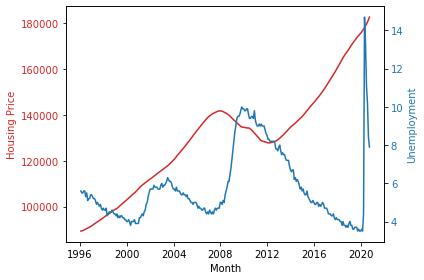

In [20]:
dual_axis(df.DATE, df.Price, df.UNRATE, "Housing Price", "Unemployment")

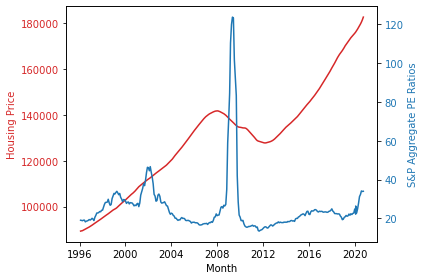

In [21]:
dual_axis(df.DATE, df.Price, df.PE_Ratio, "Housing Price", "S&P Aggregate PE Ratios")

In [22]:
# Drop Growh rate variables and Date for modeling
df = df.drop(columns = ['SP500 Growth', 'GDP Growh', 'DATE'])


# Run Graingers Causality Test for Time Series variables

In [23]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

causality = grangers_causation_matrix(df, variables = df.columns) 

- P Values of Less than .05 are significant. One can assume the one variable causes the other
- Examping the price as the y variable all variables are significant

,Price_x,MORTGAGE30US_x,GDP_x,UNRATE_x,UMCSENT_x,HOUST_x,SP_Value_x,PE_Ratio_x
Price_y,False,True,True,True,True,True,True,True


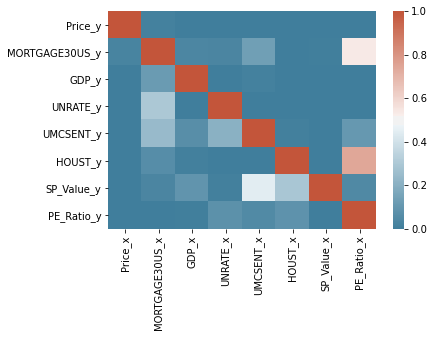

In [24]:
def gcause(df, threshold):
    if df.value < threshold:
        cause = "Yes"
    else:
        cause = "No"
    return cause


cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(causality, cmap = cmap)
causality.apply(lambda x: x < .05, axis = 1).iloc[:1]

In [25]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Price  ::  284.12    > 143.6691  =>   True
MORTGAGE30US ::  204.29    > 111.7797  =>   True
GDP    ::  137.24    > 83.9383   =>   True
UNRATE ::  88.22     > 60.0627   =>   True
UMCSENT ::  41.94     > 40.1749   =>   True
HOUST  ::  10.0      > 24.2761   =>   False
SP_Value ::  4.1       > 12.3212   =>   False
PE_Ratio ::  0.23      > 4.1296    =>   False


# Check for Stationarity

In [26]:
nobs = 12
df_train, df_test = df[0:-nobs], df[-nobs:]

In [27]:
# Augmented Dickey-Fuller Test (ADF Test)/unit root test
from statsmodels.tsa.stattools import adfuller
def adf_test(ts, signif=0.05):
    dftest = adfuller(ts, autolag='AIC')
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    for key,value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)
    
    p = adf['p-value']
    if p <= signif:
        print(f" Series is Stationary")
    else:
        print(f" Series is Non-Stationary")
#apply adf test on the series
adf_test(df_train["Price"])


Test Statistic           -0.405260
p-value                   0.909217
# Lags                   16.000000
# Observations          271.000000
Critical Value (1%)      -3.454713
Critical Value (5%)      -2.872265
Critical Value (10%)     -2.572485
dtype: float64
 Series is Non-Stationary


# Need two levels of differencing to make stationary

In [28]:
df_differenced = df_train.diff().diff().dropna()

In [29]:
adf_test(df_differenced["Price"])

Test Statistic           -3.112036
p-value                   0.025675
# Lags                   16.000000
# Observations          269.000000
Critical Value (1%)      -3.454896
Critical Value (5%)      -2.872345
Critical Value (10%)     -2.572528
dtype: float64
 Series is Stationary


# Find the best lag for VAR

In [30]:
from statsmodels.tsa.api import VAR
model = VAR(df_differenced)
x = model.select_order(maxlags=12)
x.summary()


,AIC,BIC,FPE,HQIC
0,34.83,34.94,1.341e+15,34.87
1,33.17,34.12,2.541e+14,33.55
2,31.51,33.30*,4.821e+13,32.23
3,30.85,33.49,2.513e+13,31.91
4,30.52,34.00,1.806e+13,31.91
5,30.14,34.47,1.257e+13,31.88*
6,30.00,35.17,1.103e+13,32.08
7,29.61,35.62,7.594e+12,32.02
8,29.53*,36.39,7.225e+12*,32.29
9,29.55,37.25,7.581e+12,32.64


In [31]:
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  33.11317937300378
BIC :  34.035913481703226
FPE :  240405315180561.34
HQIC:  33.48308051541309 

Lag Order = 2
AIC :  31.38089717323378
BIC :  33.12829328728281
FPE :  42564579029335.984
HQIC:  32.08146379996265 

Lag Order = 3
AIC :  30.756808193276246
BIC :  33.33309575344815
FPE :  22862113311721.492
HQIC:  31.789810824308574 

Lag Order = 4
AIC :  30.443086810148444
BIC :  33.85253172762242
FPE :  16788316659989.01
HQIC:  31.810311245299054 

Lag Order = 5
AIC :  30.096106176351643
BIC :  34.34301127080526
FPE :  11963573183789.86
HQIC:  31.7993536755022 

Lag Order = 6
AIC :  29.936969779234357
BIC :  35.02567522367131
FPE :  10330172534370.27
HQIC:  31.978057245250383 

Lag Order = 7
AIC :  29.531516102264288
BIC :  35.466399874703505
FPE :  7008670369181.7705
HQIC:  31.912276266641157 

Lag Order = 8
AIC :  29.4650918376939
BIC :  36.25057017984905
FPE :  6716517420285.807
HQIC:  32.1873734489806 

Lag Order = 9
AIC :  29.50971077298728
BIC :  37.15023865606

In [32]:
results = model.fit(maxlags=8, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 25, Nov, 2020
Time:                     19:21:57
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    36.2506
Nobs:                     278.000    HQIC:                   32.1874
Log likelihood:          -6731.37    FPE:                6.71652e+12
AIC:                      29.4651    Det(Omega_mle):     1.25069e+12
--------------------------------------------------------------------
Results for equation Price
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.381198         1.988941            0.192           0.848
L1.Price                0.518823         0.068183            7.609           0.000
L1.MORTGAGE30US        16.931534        13.550392   

In [33]:
# Run Forecasting  on Train/Test Dataset

In [34]:
# forecasting
pred = results.forecast(results.y, steps=nobs)
df_forecast = pd.DataFrame(pred, index=df.index[-nobs:], columns=df.columns + '_1d')
# inverting transformation
def invert_transformation(df_train, df_forecast, second_diff=True):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_1d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc
# show inverted results in a dataframe
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        


In [35]:
results = pd.concat([df_test['Price'],df_results['Price_forecast']], axis = 1)

In [36]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

print(r2_score(results.Price, results.Price_forecast))
print(np.sqrt(mean_squared_error(results.Price, results.Price_forecast)))


0.7220854177312909
1153.704414728789


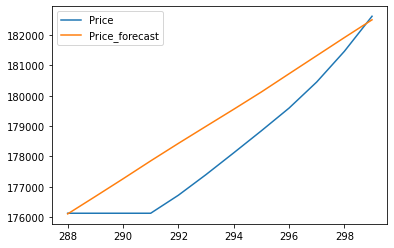

In [37]:
results.plot()

# Results were good on the original train/test test but that only evaluates the prediction performance on the last 12 months of the dataset which was relatively straightforward and linear



#### the next step will assess the performance over multiple time periods including the '08' housing market dip 

In [38]:
df = avg_c2.merge(dfMacro, on = 'DATE', how = 'left')
df = df.drop(columns = ['SP500 Growth', 'GDP Growh', 'DATE'])

In [39]:
lst_accuracy = []

#Run a series of tests using a 12 month prediction time frame 

# the loop will start with training on months 0 through 130 predicting + 12 months
# then train on 0 through 142, predict + 12 months
# train on months 0 through 154, predict + months out
# and so on

for n in range(0,10):
    
    dfx = df[:130 + (n*12)]
    nobs = 12
    df_train, df_test = dfx[0:-nobs], dfx[-nobs:]
    df_differenced = df_train.diff().diff().dropna()
    model = VAR(df_differenced)
    results = model.fit(maxlags=8, ic='aic')
    pred = results.forecast(results.y, steps=nobs)
    df_forecast = pd.DataFrame(pred, index=dfx.index[-nobs:], columns=dfx.columns + '_1d')
    df_results = invert_transformation(df_train, df_forecast, second_diff=True)  
    accuracy = pd.concat([df_test['Price'],df_results['Price_forecast']], axis = 1)
    
    lst_accuracy.append(accuracy)
    
    

0.920373222371028
1309.702075224045


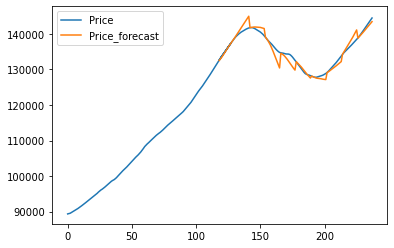

In [40]:
fullbacktest =pd.concat(lst_accuracy)
print(r2_score(fullbacktest.Price, fullbacktest.Price_forecast))
print(np.sqrt(mean_squared_error(fullbacktest.Price, fullbacktest.Price_forecast)))

pd.concat([df[['Price']][:128],fullbacktest]).plot()

### Time to Run model through each city/state combo to get predictions by city/state

Write the necessary functions

In [41]:
# forecasting

def var(df, nobs, rt = 'last'):
    
    df_train = df.drop(columns = 'CityState').sort_values(by = 'DATE')
    df_train.drop(columns = 'DATE', inplace = True)
    df_differenced = df_train.diff().diff().dropna()
    model = VAR(df_differenced)
    results = model.fit(maxlags=8, ic='aic')
    pred = results.forecast(results.y, steps=nobs)
    df_forecast = pd.DataFrame(pred, index=df_train.index[-nobs:], columns=df_train.columns + '_1d')
    df_results = invert_transformation(df_train, df_forecast, second_diff=True)
    
    
    
    
    if rt == 'last':
        return df_results.Price_forecast.values[-1]
    else:
        return df_results.Price_forecast.values

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#Function to calculate principle and interest on mortgage
def mortgage(row, Down,Type,Rate,rt):
    
    Price = row['Price']
    Sales_Price = float(Price)
    Down_Payment =  float(Down)
    Loan_Amount = Sales_Price - Down_Payment
    Mortgage_Type =  float(Type)
    Loan_Term = int(12*Mortgage_Type)
    Interest_Rate =  float(Rate)
    R = 1 +(Interest_Rate)/(12*100)
    X = Loan_Amount*(R**Loan_Term)*(1-R)/(1-R**Loan_Term)
    Monthly_Interest = []
    Monthly_Balance  = []
    Monthly_P = []
    for i in range(1,Loan_Term+1):
        Interest = Loan_Amount*(R-1)
        P = X - Interest
        Loan_Amount = Loan_Amount - (X-Interest)
        Monthly_Interest = np.append(Monthly_Interest,Interest)
        Monthly_P = np.append(Monthly_P,P)
        Monthly_Balance = np.append(Monthly_Balance, Loan_Amount)
        
    schedule = pd.DataFrame({'P': Monthly_P, 'I':Monthly_Interest, 'Remaining':Monthly_Balance})[0:12]
    schedule['Payment'] = schedule.P + schedule.I
    
    if rt == 'I':
        return schedule[0:12].I.sum()
    if rt =='P':
        return schedule[0:12].P.sum()

In [43]:
def PriceForecast(cluster):
#Merge Available Rent with Homevalues

    dfRental = pd.read_csv('Zillow Rental by Zip.csv')
    dfRental = dfRental[['RegionName','2020-09']]
    dfRental.columns = ['ZipCode', 'Rent']
    dfMerged = HomeValues.merge(dfRental, on = 'ZipCode').drop(columns = "Unnamed: 0").dropna()
    dfMerged['CityState'] = dfMerged.City + '-' + dfMerged.State


    #filter to cluster 2, summarize by cluster 2 average values, merge with Macro Eco Data
    MetroGroup = dfMerged[dfMerged.labels == cluster].groupby(['Date','CityState'])['Price'].mean().reset_index()
    MetroGroup.columns = ['DATE','CityState', 'Price']
    MetroGroup.DATE = pd.to_datetime(MetroGroup.DATE)
    df = MetroGroup.merge(dfMacro, on = 'DATE')
    df = df.drop(columns = ['SP500 Growth', 'GDP Growh'])

    #Get City/State Combos in my price range
    dfFiltered = df[df.DATE == '2020-09-30']
    dfFiltered = dfFiltered[(dfFiltered.Price > 200000) & (dfFiltered.Price < 350000)]


    #forecast pricing model for each city/state
    metro_list = dfFiltered.CityState.value_counts().index

    lstfcst = []

    for n in metro_list:
        fcst = var(df[df.CityState == n],12)
        lstfcst.append(fcst)

    MetroForecasts = pd.DataFrame({'CityState':metro_list, 'Price_f': lstfcst})

    ForecastbyCity = dfFiltered.merge(MetroForecasts, on = 'CityState')
    ForecastbyCity['PriceInc'] = (ForecastbyCity.Price_f - ForecastbyCity.Price)/ForecastbyCity.Price
    ForecastbyCity = ForecastbyCity[['CityState','Price','Price_f','PriceInc']].sort_values(by = 'PriceInc')
    dfRentSum = dfMerged[dfMerged.Date =='2020-09-30'].groupby('CityState')['Rent'].mean().reset_index()

    ReturnSum = ForecastbyCity.merge(dfRentSum, on = 'CityState')
    ReturnSum['RentalReturn'] = ReturnSum.Rent/ReturnSum.Price
    ReturnSum['TotalReturn'] = ReturnSum.RentalReturn + ReturnSum.PriceInc

    ReturnSum['Interest'] = ReturnSum.apply(mortgage, axis = 1, Down = 60000, Type = 30, Rate = 3, rt = 'I')
    ReturnSum['Princple'] = ReturnSum.apply(mortgage, axis = 1, Down = 60000, Type = 30, Rate = 3, rt = 'P')
    ReturnSum['MonthlyCash'] = ReturnSum.Rent  - (ReturnSum.Princple + ReturnSum.Interest)/12
    ReturnSum['NetRentReturn'] = (ReturnSum.Rent * 12) - ReturnSum.Interest
    ReturnSum['TotalReturn'] = (ReturnSum.Price_f - ReturnSum.Price) + ReturnSum.NetRentReturn
    ReturnSum['TotalReturn_Per'] = ReturnSum.TotalReturn/ReturnSum.Price
    ReturnSum['Cluster'] = cluster
    return ReturnSum

In [44]:
#create forecasts for each cluster

c0 = PriceForecast(0).sort_values(by = 'TotalReturn_Per', ascending = False)
c1 = PriceForecast(1).sort_values(by = 'TotalReturn_Per', ascending = False)
c2 = PriceForecast(2).sort_values(by = 'TotalReturn_Per', ascending = False)
c3 = PriceForecast(3).sort_values(by = 'TotalReturn_Per', ascending = False)



In [142]:
#export for tableau

full = pd.concat([c0, c2, c3, c1])
full = full[full.CityState.duplicated() == False]
full.shape

(490, 13)

In [143]:
full.to_csv('HomeForecasts.csv')

In [68]:
def graph_price(citystate):
    Actuals = df[df.CityState == citystate][['DATE','Price']].set_index('DATE')
    Actuals['Type'] = 'Actual'
    Forecast = var(df[df.CityState == citystate], 12, rt = 'all')
    lastdate = Actuals.index[-1]
    dtarray = []
    for i in range(1,len(Forecast)+1):
        dtarray.append(pd.to_datetime(lastdate) + MonthEnd(i))
        
    dfForecast = pd.DataFrame({'Price':Forecast,'Type':'Forecast'}, index = dtarray)
    Prices = pd.concat([Actuals,dfForecast])
    Prices['pct_change'] = Prices.Price.pct_change()
    sns.lineplot(data = Prices, x = Prices.index, y = 'Price', hue= 'Type')
    return Prices

,Price,Type,pct_change
1996-01-31,65087.000000,Actual,NaN
1996-02-29,65179.000000,Actual,0.001413
1996-03-31,65429.000000,Actual,0.003836
1996-04-30,65844.000000,Actual,0.006343
1996-05-31,66337.000000,Actual,0.007487
...,...,...,...
2021-05-31,278235.979454,Forecast,0.018013
2021-06-30,283309.020661,Forecast,0.018233
2021-07-31,290325.902785,Forecast,0.024768
2021-08-31,294727.827039,Forecast,0.015162


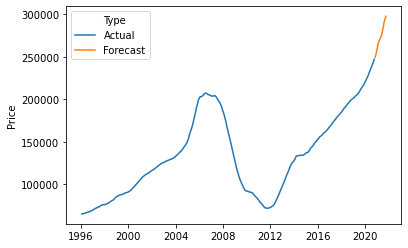

In [71]:
graph_price(85041)

In [802]:
mortgage = pd.DataFrame({'P': Monthly_P, 'I':Monthly_Interest, 'Remaining':Monthly_Balance})
mortgage['Payment'] = mortgage.P + mortgage.I
pd.set_option('display.float_format', lambda x: '%.5f' % x)
mortgage[0:12].P.sum()
mortgage[0:12].I.sum()
mortgage[0:12]['Payment'].sum()

8714.960117060049

### Ignore for Now

In [19]:
import xgboost

In [20]:

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        # put it all together
    agg = pd.concat(cols, axis=1)
        # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [88]:
df['MA'] = df.Price.shift(1).rolling(window = 1).mean()

In [89]:
df = df.dropna()

In [90]:
df

,DATE,Price,MORTGAGE30US,GDP,GDP Growh,UNRATE,UMCSENT,HOUST,SP_Value,SP500 Growth,PE_Ratio,MA
4,1996-05-31,89999.968669,8.0700,10998.322,0.016678,5.6,89.4,1504.0,661.23,0.021725,19.10,89776.250995
5,1996-06-30,90217.281115,8.3200,10998.322,0.016678,5.3,92.4,1467.0,668.50,0.010995,19.15,89999.968669
6,1996-07-31,90426.130518,8.2450,11096.976,0.008970,5.5,94.7,1472.0,644.07,-0.036545,18.26,90217.281115
7,1996-08-31,90657.666090,8.0020,11096.976,0.008970,5.1,95.3,1557.0,662.68,0.028894,18.60,90426.130518
8,1996-09-30,90888.407478,8.2300,11096.976,0.008970,5.2,94.7,1475.0,674.88,0.018410,18.75,90657.666090
...,...,...,...,...,...,...,...,...,...,...,...,...
295,2020-05-31,178843.742773,3.2325,17302.511,-0.089861,13.3,72.3,1038.0,2919.61,0.002465,27.82,178116.717674
296,2020-06-30,179591.444868,3.1625,17302.511,-0.089861,11.1,78.1,1265.0,3104.66,0.063382,31.29,178843.742773
297,2020-07-31,180451.367319,3.0160,18583.984,0.074063,10.2,72.5,1487.0,3207.62,0.034619,32.33,179591.444868
298,2020-08-31,181462.588368,2.9350,18583.984,0.074063,8.4,74.1,1373.0,3391.71,0.036865,34.18,180451.367319


In [91]:
y = df.Price
X = df.drop(columns = ['DATE', 'Price'])

In [92]:
from sklearn.preprocessing import StandardScaler
scaler =StandardScaler().fit(X)
X_scale = scaler.transform(X)

In [93]:
def train_test(data, percent = .9):
    n = round(len(data)*.9)
    n2 = len(data) - n
    train = data[:n]
    test = data[n:]
    
    return train, test

In [94]:
X_train, X_test = train_test(X_scale)
y_train, y_test = train_test(y)

In [69]:
from xgboost import XGBRegressor

In [71]:
# fit model
model = XGBRegressor()
model = XGBRegressor(n_estimators=1000)
model.fit(X_train, y_train.ravel())

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [65]:
from sklearn.linear_model import LinearRegression

In [72]:
ypred = model.predict(X_test)

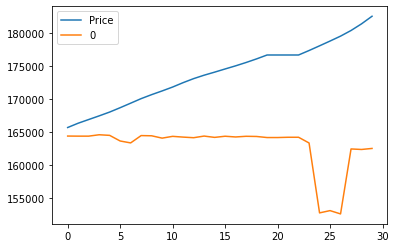

In [73]:
import matplotlib.pyplot as plt
pd.DataFrame(ypred, y_test).reset_index().plot()

In [99]:
modlin = LinearRegression()
modlin.fit(X_train, y_train)



X_test

array([[-0.6227633 ,  1.53758133, -0.01142236, -1.03223528,  0.73746727,
        -0.27334005,  1.89741303,  0.22241621, -0.21858089,  1.51191298],
       [-0.60757309,  1.53758133, -0.01142236, -1.03223528,  0.60613462,
        -0.07896902,  1.99563033,  0.4534102 , -0.21595742,  1.54377718],
       [-0.55525125,  1.53758133, -0.01142236, -1.08486043,  0.90742716,
        -0.15671743,  2.06247563,  0.2494618 , -0.22382782,  1.57270605],
       [-0.41853935,  1.56554381, -0.15813336, -1.03223528,  0.79154541,
        -0.24589943,  1.88489483, -1.21671216, -0.2894145 ,  1.59739581],
       [-0.39423501,  1.56554381, -0.15813336, -1.08486043,  0.70656547,
        -0.25275959,  1.7896617 , -0.74850996, -0.32745477,  1.62205451],
       [-0.54850004,  1.56554381, -0.15813336, -0.97961012,  0.76836907,
        -0.45170405,  1.55105089, -1.674579  , -0.41140571,  1.64768691],
       [-0.66563345,  1.62750382,  0.13756357, -0.92698497,  0.21986213,
        -0.09726277,  1.61238697,  0.2581429 

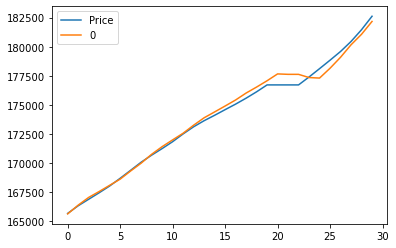

In [96]:
pd.DataFrame(y_pred, y_test).reset_index().plot()

In [97]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

In [98]:
print(r2_score(y_pred, y_test))
print(np.sqrt(mean_squared_error(y_pred, y_test)))

0.9914452864797514
422.47341316062466


In [86]:
from sklearn.ensemble import RandomForestRegressor

-17.375009467427816
14734.468989191522


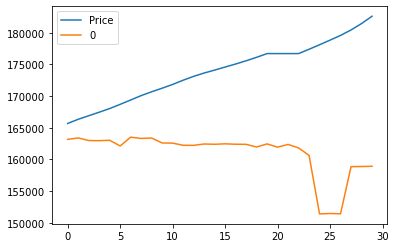

In [87]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(r2_score(y_pred, y_test))
print(np.sqrt(mean_squared_error(y_pred, y_test)))
pd.DataFrame(y_pred, y_test).reset_index().plot()